In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Device setup for MPS (Metal Performance Shaders)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS (Metal Performance Shaders) backend is available.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available, using CPU.")

# Define the AdvancedTransform class for training
class AdvancedTransform:
    def __init__(self):
        self.common_augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=(-15, 15)),
            transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        ])
        
        self.image_augmentation = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

    def __call__(self, image, mask):
        seed = random.randint(0, 2**32)
        
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.common_augmentation(image)
        
        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.common_augmentation(mask)

        image = self.image_augmentation(image)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

# Define a simple transform class for validation
class SimpleTransform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __call__(self, image, mask):
        image = self.transform(image)
        mask = self.transform(mask)
        return image, mask

# Define the KvasirSegDataset class
class KvasirSegDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
 
        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Get image and mask paths
img_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/images'
mask_dir = '/Users/snirtahasa/Desktop/Studies/Deep Learning/Home Assignment/Final Project/Kasvir-SEG1/Kvasir-SEG/Kvasir-SEG/masks'

image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)]

# Split data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Create the advanced transform object for training
advanced_transform = AdvancedTransform()

# Create the simple transform object for validation
simple_transform = SimpleTransform()

# Create datasets with the appropriate transform
train_dataset = KvasirSegDataset(train_image_paths, train_mask_paths, transform=advanced_transform)
val_dataset = KvasirSegDataset(val_image_paths, val_mask_paths, transform=simple_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


MPS (Metal Performance Shaders) backend is available.


In [2]:
import torch
import torch.nn as nn

# Define the SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        se = self.global_avg_pool(x)
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se)
        return x * se

# Define the CBAM block
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.global_avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.global_max_pool(x))))
        return x * self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, in_channels, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=(kernel_size - 1) // 2)
        self.sigmoid = nn.Sigmoid()
        self.expand_channels = nn.Conv2d(1, in_channels, kernel_size=1)  # Add this line

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.sigmoid(self.conv(x))
        x = self.expand_channels(x)  # Add this line
        return x * x


class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(in_channels, kernel_size)  # Pass in_channels

    def forward(self, x):
        x = self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


# Define the U-Net architecture with SE and CBAM blocks
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=128):
        super(UNet, self).__init__()

        features = init_features
        self.down1 = self.conv_block(in_channels, features)
        self.down2 = self.conv_block(features, features * 2)
        self.down3 = self.conv_block(features * 2, features * 4)
        self.down4 = self.conv_block(features * 4, features * 8)
        self.down5 = self.conv_block(features * 8, features * 16)

        self.up1 = self.up_conv_block(features * 16, features * 8)
        self.up_conv1 = self.conv_block(features * 16, features * 8)
        self.up2 = self.up_conv_block(features * 8, features * 4)
        self.up_conv2 = self.conv_block(features * 8, features * 4)
        self.up3 = self.up_conv_block(features * 4, features * 2)
        self.up_conv3 = self.conv_block(features * 4, features * 2)
        self.up4 = self.up_conv_block(features * 2, features)
        self.up_conv4 = self.conv_block(features * 2, features)
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),  # BatchNorm before CBAM
            SEBlock(out_channels),  # Add SEBlock after BatchNorm
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            CBAM(out_channels),  # Add CBAM after the second convolution
        )

    def up_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(nn.functional.max_pool2d(down1, 2))
        down3 = self.down3(nn.functional.max_pool2d(down2, 2))
        down4 = self.down4(nn.functional.max_pool2d(down3, 2))
        down5 = self.down5(nn.functional.max_pool2d(down4, 2))

        up1 = self.up1(down5)
        up1 = torch.cat([up1, down4], dim=1)
        up1 = self.up_conv1(up1)
        up2 = self.up2(up1)
        up2 = torch.cat([up2, down3], dim=1)
        up2 = self.up_conv2(up2)
        up3 = self.up3(up2)
        up3 = torch.cat([up3, down2], dim=1)
        up3 = self.up_conv3(up3)
        up4 = self.up4(up3)
        up4 = torch.cat([up4, down1], dim=1)
        up4 = self.up_conv4(up4)

        out = self.final_conv(up4)
        return self.sigmoid(out)


In [3]:
# Adjust init_features to control the width of the network
Attntion_WD_Aug_model = UNet(in_channels=3, out_channels=1, init_features=64).to(device)

In [4]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(Attntion_WD_Aug_model.parameters(), lr=0.01, momentum=0.9)

# Define metrics: Dice coefficient and IoU
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    dice = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    union = (pred + target).sum(dim=2).sum(dim=2) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

In [5]:
# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Attntion_WD_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Attntion_WD_Aug_model(images)
        loss = criterion(outputs, masks)a
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Attntion_WD_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Attntion_WD_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [1/50], Loss: 0.4364
Epoch [1/50], Validation Loss: 0.3561, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 2/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [2/50], Loss: 0.3982
Epoch [2/50], Validation Loss: 0.3595, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 3/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [3/50], Loss: 0.3966
Epoch [3/50], Validation Loss: 0.3509, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 4/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [4/50], Loss: 0.3936
Epoch [4/50], Validation Loss: 0.3561, Validation Dice: 0.0000, Validation IoU: 0.0000


Epoch 5/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [5/50], Loss: 0.3884
Epoch [5/50], Validation Loss: 0.3422, Validation Dice: 0.1130, Validation IoU: 0.0730


Epoch 6/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [6/50], Loss: 0.3775
Epoch [6/50], Validation Loss: 0.3259, Validation Dice: 0.0010, Validation IoU: 0.0005


Epoch 7/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [7/50], Loss: 0.3626
Epoch [7/50], Validation Loss: 0.3407, Validation Dice: 0.4401, Validation IoU: 0.3200


Epoch 8/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [8/50], Loss: 0.3512
Epoch [8/50], Validation Loss: 0.3196, Validation Dice: 0.4090, Validation IoU: 0.2922


Epoch 9/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [9/50], Loss: 0.3384
Epoch [9/50], Validation Loss: 0.3168, Validation Dice: 0.4125, Validation IoU: 0.2966


Epoch 10/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [10/50], Loss: 0.3288
Epoch [10/50], Validation Loss: 0.4387, Validation Dice: 0.4600, Validation IoU: 0.3292


Epoch 11/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [11/50], Loss: 0.3234
Epoch [11/50], Validation Loss: 0.2890, Validation Dice: 0.2602, Validation IoU: 0.1909


Epoch 12/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [12/50], Loss: 0.3126
Epoch [12/50], Validation Loss: 0.3045, Validation Dice: 0.4544, Validation IoU: 0.3449


Epoch 13/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [13/50], Loss: 0.3037
Epoch [13/50], Validation Loss: 0.3807, Validation Dice: 0.5348, Validation IoU: 0.4041


Epoch 14/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [14/50], Loss: 0.2932
Epoch [14/50], Validation Loss: 0.2579, Validation Dice: 0.4358, Validation IoU: 0.3405


Epoch 15/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [15/50], Loss: 0.2830
Epoch [15/50], Validation Loss: 0.2783, Validation Dice: 0.5729, Validation IoU: 0.4557


Epoch 16/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [16/50], Loss: 0.2731
Epoch [16/50], Validation Loss: 0.2824, Validation Dice: 0.3819, Validation IoU: 0.2940


Epoch 17/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [17/50], Loss: 0.2522
Epoch [17/50], Validation Loss: 0.2686, Validation Dice: 0.6044, Validation IoU: 0.4855


Epoch 18/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [18/50], Loss: 0.2378
Epoch [18/50], Validation Loss: 0.2288, Validation Dice: 0.6786, Validation IoU: 0.5690


Epoch 19/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [19/50], Loss: 0.2303
Epoch [19/50], Validation Loss: 0.2111, Validation Dice: 0.6533, Validation IoU: 0.5468


Epoch 20/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [20/50], Loss: 0.2194
Epoch [20/50], Validation Loss: 0.2066, Validation Dice: 0.7118, Validation IoU: 0.6007


Epoch 21/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [21/50], Loss: 0.2122
Epoch [21/50], Validation Loss: 0.1891, Validation Dice: 0.7114, Validation IoU: 0.6089


Epoch 22/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [22/50], Loss: 0.1957
Epoch [22/50], Validation Loss: 0.2074, Validation Dice: 0.7346, Validation IoU: 0.6300


Epoch 23/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [23/50], Loss: 0.1937
Epoch [23/50], Validation Loss: 0.2239, Validation Dice: 0.5866, Validation IoU: 0.4908


Epoch 24/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [24/50], Loss: 0.1911
Epoch [24/50], Validation Loss: 0.1738, Validation Dice: 0.7249, Validation IoU: 0.6266


Epoch 25/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [25/50], Loss: 0.1851
Epoch [25/50], Validation Loss: 0.2329, Validation Dice: 0.5049, Validation IoU: 0.4198


Epoch 26/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [26/50], Loss: 0.1869
Epoch [26/50], Validation Loss: 0.2010, Validation Dice: 0.6229, Validation IoU: 0.5358


Epoch 27/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [27/50], Loss: 0.1725
Epoch [27/50], Validation Loss: 0.1508, Validation Dice: 0.7873, Validation IoU: 0.6885


Epoch 28/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [28/50], Loss: 0.1655
Epoch [28/50], Validation Loss: 0.1594, Validation Dice: 0.7914, Validation IoU: 0.7008


Epoch 29/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [29/50], Loss: 0.1804
Epoch [29/50], Validation Loss: 0.1490, Validation Dice: 0.7898, Validation IoU: 0.7001


Epoch 30/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [30/50], Loss: 0.1672
Epoch [30/50], Validation Loss: 0.1477, Validation Dice: 0.7857, Validation IoU: 0.6920


Epoch 31/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [31/50], Loss: 0.1574
Epoch [31/50], Validation Loss: 0.2201, Validation Dice: 0.7148, Validation IoU: 0.6071


Epoch 32/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [32/50], Loss: 0.1651
Epoch [32/50], Validation Loss: 0.1539, Validation Dice: 0.7905, Validation IoU: 0.7017


Epoch 33/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [33/50], Loss: 0.1620
Epoch [33/50], Validation Loss: 0.1460, Validation Dice: 0.7930, Validation IoU: 0.7049


Epoch 34/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [34/50], Loss: 0.1537
Epoch [34/50], Validation Loss: 0.1407, Validation Dice: 0.8105, Validation IoU: 0.7242


Epoch 35/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [35/50], Loss: 0.1557
Epoch [35/50], Validation Loss: 0.1582, Validation Dice: 0.7976, Validation IoU: 0.7099


Epoch 36/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [36/50], Loss: 0.1516
Epoch [36/50], Validation Loss: 0.1298, Validation Dice: 0.8316, Validation IoU: 0.7448


Epoch 37/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [37/50], Loss: 0.1473
Epoch [37/50], Validation Loss: 0.1889, Validation Dice: 0.7668, Validation IoU: 0.6658


Epoch 38/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [38/50], Loss: 0.1513
Epoch [38/50], Validation Loss: 0.1626, Validation Dice: 0.7608, Validation IoU: 0.6669


Epoch 39/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [39/50], Loss: 0.1472
Epoch [39/50], Validation Loss: 0.1718, Validation Dice: 0.7817, Validation IoU: 0.6897


Epoch 40/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [40/50], Loss: 0.1408
Epoch [40/50], Validation Loss: 0.1581, Validation Dice: 0.7959, Validation IoU: 0.7022


Epoch 41/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [41/50], Loss: 0.1530
Epoch [41/50], Validation Loss: 0.1320, Validation Dice: 0.8294, Validation IoU: 0.7443


Epoch 42/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [42/50], Loss: 0.1378
Epoch [42/50], Validation Loss: 0.1312, Validation Dice: 0.8055, Validation IoU: 0.7214


Epoch 43/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [43/50], Loss: 0.1423
Epoch [43/50], Validation Loss: 0.1372, Validation Dice: 0.7798, Validation IoU: 0.6973


Epoch 44/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [44/50], Loss: 0.1401
Epoch [44/50], Validation Loss: 0.1437, Validation Dice: 0.7964, Validation IoU: 0.7089


Epoch 45/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [45/50], Loss: 0.1339
Epoch [45/50], Validation Loss: 0.1406, Validation Dice: 0.8213, Validation IoU: 0.7356


Epoch 46/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [46/50], Loss: 0.1300
Epoch [46/50], Validation Loss: 0.1615, Validation Dice: 0.8049, Validation IoU: 0.7148


Epoch 47/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [47/50], Loss: 0.1328
Epoch [47/50], Validation Loss: 0.1415, Validation Dice: 0.8135, Validation IoU: 0.7347


Epoch 48/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [48/50], Loss: 0.1281
Epoch [48/50], Validation Loss: 0.1269, Validation Dice: 0.8332, Validation IoU: 0.7503


Epoch 49/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [49/50], Loss: 0.1206
Epoch [49/50], Validation Loss: 0.1331, Validation Dice: 0.8282, Validation IoU: 0.7446


Epoch 50/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [50/50], Loss: 0.1275
Epoch [50/50], Validation Loss: 0.1519, Validation Dice: 0.8038, Validation IoU: 0.7179


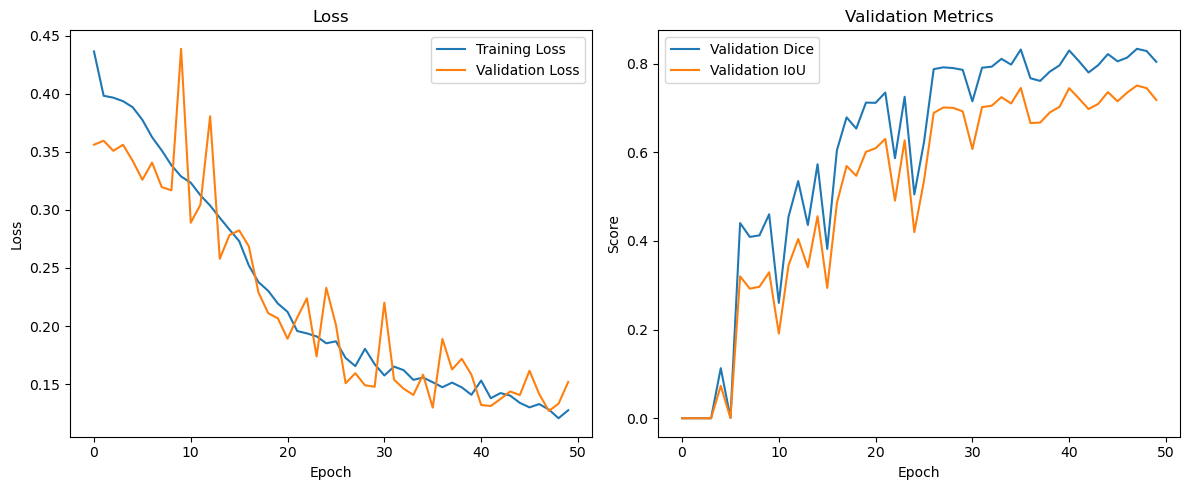

In [6]:
# Plot the loss and validation metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dice_scores, label='Validation Dice')
plt.plot(val_ious, label='Validation IoU')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Training and validation loop
num_epochs = 50
train_losses = []
val_losses = []  # To store validation loss
val_dice_scores = []
val_ious = []

for epoch in range(num_epochs):
    Attntion_WD_Aug_model.train()
    epoch_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = Attntion_WD_Aug_model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation
    Attntion_WD_Aug_model.eval()
    val_loss = 0.0  # Initialize validation loss
    val_dice = 0.0
    val_iou = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = Attntion_WD_Aug_model(images)
            loss = criterion(outputs, masks)  # Compute validation loss
            val_loss += loss.item() * images.size(0)
            preds = outputs > 0.5
            val_dice += dice_coefficient(preds, masks).item() * images.size(0)
            val_iou += iou(preds, masks).item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)  # Store validation loss
    val_dice /= len(val_loader.dataset)
    val_dice_scores.append(val_dice)
    val_iou /= len(val_loader.dataset)
    val_ious.append(val_iou)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}, Validation IoU: {val_iou:.4f}')

Epoch 1/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [1/50], Loss: 0.1206
Epoch [1/50], Validation Loss: 0.1253, Validation Dice: 0.8245, Validation IoU: 0.7443


Epoch 2/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [2/50], Loss: 0.1263
Epoch [2/50], Validation Loss: 0.1169, Validation Dice: 0.8283, Validation IoU: 0.7473


Epoch 3/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [3/50], Loss: 0.1180
Epoch [3/50], Validation Loss: 0.1217, Validation Dice: 0.8217, Validation IoU: 0.7435


Epoch 4/50: 100%|█████████████████████████████| 200/200 [02:58<00:00,  1.12it/s]


Epoch [4/50], Loss: 0.1157
Epoch [4/50], Validation Loss: 0.1436, Validation Dice: 0.8026, Validation IoU: 0.7135


Epoch 5/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [5/50], Loss: 0.1200
Epoch [5/50], Validation Loss: 0.1333, Validation Dice: 0.7931, Validation IoU: 0.7139


Epoch 6/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [6/50], Loss: 0.1139
Epoch [6/50], Validation Loss: 0.1301, Validation Dice: 0.7699, Validation IoU: 0.6862


Epoch 7/50: 100%|█████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [7/50], Loss: 0.1133
Epoch [7/50], Validation Loss: 0.1469, Validation Dice: 0.8041, Validation IoU: 0.7158


Epoch 8/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [8/50], Loss: 0.1109
Epoch [8/50], Validation Loss: 0.1274, Validation Dice: 0.8393, Validation IoU: 0.7576


Epoch 9/50: 100%|█████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [9/50], Loss: 0.1159
Epoch [9/50], Validation Loss: 0.1163, Validation Dice: 0.8465, Validation IoU: 0.7665


Epoch 10/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [10/50], Loss: 0.1038
Epoch [10/50], Validation Loss: 0.1193, Validation Dice: 0.8481, Validation IoU: 0.7684


Epoch 11/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [11/50], Loss: 0.1086
Epoch [11/50], Validation Loss: 0.1239, Validation Dice: 0.8406, Validation IoU: 0.7608


Epoch 12/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [12/50], Loss: 0.1056
Epoch [12/50], Validation Loss: 0.1643, Validation Dice: 0.7813, Validation IoU: 0.6938


Epoch 13/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [13/50], Loss: 0.1097
Epoch [13/50], Validation Loss: 0.1340, Validation Dice: 0.8090, Validation IoU: 0.7213


Epoch 14/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [14/50], Loss: 0.1096
Epoch [14/50], Validation Loss: 0.1315, Validation Dice: 0.7997, Validation IoU: 0.7174


Epoch 15/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [15/50], Loss: 0.1100
Epoch [15/50], Validation Loss: 0.1592, Validation Dice: 0.7869, Validation IoU: 0.6972


Epoch 16/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [16/50], Loss: 0.1069
Epoch [16/50], Validation Loss: 0.1468, Validation Dice: 0.8113, Validation IoU: 0.7286


Epoch 17/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [17/50], Loss: 0.1015
Epoch [17/50], Validation Loss: 0.1143, Validation Dice: 0.8526, Validation IoU: 0.7756


Epoch 18/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [18/50], Loss: 0.1100
Epoch [18/50], Validation Loss: 0.1409, Validation Dice: 0.8316, Validation IoU: 0.7431


Epoch 19/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [19/50], Loss: 0.1003
Epoch [19/50], Validation Loss: 0.1210, Validation Dice: 0.8391, Validation IoU: 0.7615


Epoch 20/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [20/50], Loss: 0.0948
Epoch [20/50], Validation Loss: 0.1222, Validation Dice: 0.8430, Validation IoU: 0.7665


Epoch 21/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [21/50], Loss: 0.1058
Epoch [21/50], Validation Loss: 0.1510, Validation Dice: 0.8125, Validation IoU: 0.7273


Epoch 22/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [22/50], Loss: 0.0996
Epoch [22/50], Validation Loss: 0.1290, Validation Dice: 0.8376, Validation IoU: 0.7597


Epoch 23/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [23/50], Loss: 0.0988
Epoch [23/50], Validation Loss: 0.1061, Validation Dice: 0.8561, Validation IoU: 0.7815


Epoch 24/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [24/50], Loss: 0.0949
Epoch [24/50], Validation Loss: 0.1651, Validation Dice: 0.8315, Validation IoU: 0.7577


Epoch 25/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [25/50], Loss: 0.0897
Epoch [25/50], Validation Loss: 0.1089, Validation Dice: 0.8507, Validation IoU: 0.7781


Epoch 26/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [26/50], Loss: 0.0894
Epoch [26/50], Validation Loss: 0.1205, Validation Dice: 0.8420, Validation IoU: 0.7680


Epoch 27/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.12it/s]


Epoch [27/50], Loss: 0.0969
Epoch [27/50], Validation Loss: 0.1275, Validation Dice: 0.8306, Validation IoU: 0.7453


Epoch 28/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [28/50], Loss: 0.0828
Epoch [28/50], Validation Loss: 0.1318, Validation Dice: 0.8240, Validation IoU: 0.7499


Epoch 29/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [29/50], Loss: 0.0913
Epoch [29/50], Validation Loss: 0.1532, Validation Dice: 0.7956, Validation IoU: 0.7127


Epoch 30/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [30/50], Loss: 0.0915
Epoch [30/50], Validation Loss: 0.1223, Validation Dice: 0.8317, Validation IoU: 0.7578


Epoch 31/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [31/50], Loss: 0.0839
Epoch [31/50], Validation Loss: 0.1175, Validation Dice: 0.8431, Validation IoU: 0.7664


Epoch 32/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [32/50], Loss: 0.0864
Epoch [32/50], Validation Loss: 0.1138, Validation Dice: 0.8548, Validation IoU: 0.7810


Epoch 33/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.14it/s]


Epoch [33/50], Loss: 0.0822
Epoch [33/50], Validation Loss: 0.1295, Validation Dice: 0.8353, Validation IoU: 0.7630


Epoch 34/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [34/50], Loss: 0.0812
Epoch [34/50], Validation Loss: 0.1219, Validation Dice: 0.8492, Validation IoU: 0.7729


Epoch 35/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [35/50], Loss: 0.0851
Epoch [35/50], Validation Loss: 0.1111, Validation Dice: 0.8497, Validation IoU: 0.7756


Epoch 36/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [36/50], Loss: 0.0874
Epoch [36/50], Validation Loss: 0.1150, Validation Dice: 0.8480, Validation IoU: 0.7748


Epoch 37/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [37/50], Loss: 0.0862
Epoch [37/50], Validation Loss: 0.1856, Validation Dice: 0.7975, Validation IoU: 0.7072


Epoch 38/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [38/50], Loss: 0.0930
Epoch [38/50], Validation Loss: 0.1260, Validation Dice: 0.8383, Validation IoU: 0.7583


Epoch 39/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [39/50], Loss: 0.0861
Epoch [39/50], Validation Loss: 0.1235, Validation Dice: 0.8256, Validation IoU: 0.7505


Epoch 40/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.12it/s]


Epoch [40/50], Loss: 0.0853
Epoch [40/50], Validation Loss: 0.1395, Validation Dice: 0.8359, Validation IoU: 0.7569


Epoch 41/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [41/50], Loss: 0.0871
Epoch [41/50], Validation Loss: 0.1055, Validation Dice: 0.8585, Validation IoU: 0.7839


Epoch 42/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [42/50], Loss: 0.0771
Epoch [42/50], Validation Loss: 0.1092, Validation Dice: 0.8630, Validation IoU: 0.7919


Epoch 43/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [43/50], Loss: 0.0797
Epoch [43/50], Validation Loss: 0.1773, Validation Dice: 0.7900, Validation IoU: 0.6993


Epoch 44/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [44/50], Loss: 0.0822
Epoch [44/50], Validation Loss: 0.1267, Validation Dice: 0.8402, Validation IoU: 0.7650


Epoch 45/50: 100%|████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]


Epoch [45/50], Loss: 0.0905
Epoch [45/50], Validation Loss: 0.1229, Validation Dice: 0.8166, Validation IoU: 0.7385


Epoch 46/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [46/50], Loss: 0.0895
Epoch [46/50], Validation Loss: 0.1156, Validation Dice: 0.8449, Validation IoU: 0.7680


Epoch 47/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [47/50], Loss: 0.0773
Epoch [47/50], Validation Loss: 0.1150, Validation Dice: 0.8450, Validation IoU: 0.7686


Epoch 48/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [48/50], Loss: 0.0803
Epoch [48/50], Validation Loss: 0.1096, Validation Dice: 0.8525, Validation IoU: 0.7750


Epoch 49/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [49/50], Loss: 0.0746
Epoch [49/50], Validation Loss: 0.1074, Validation Dice: 0.8506, Validation IoU: 0.7777


Epoch 50/50: 100%|████████████████████████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch [50/50], Loss: 0.0771
Epoch [50/50], Validation Loss: 0.1201, Validation Dice: 0.8523, Validation IoU: 0.7777


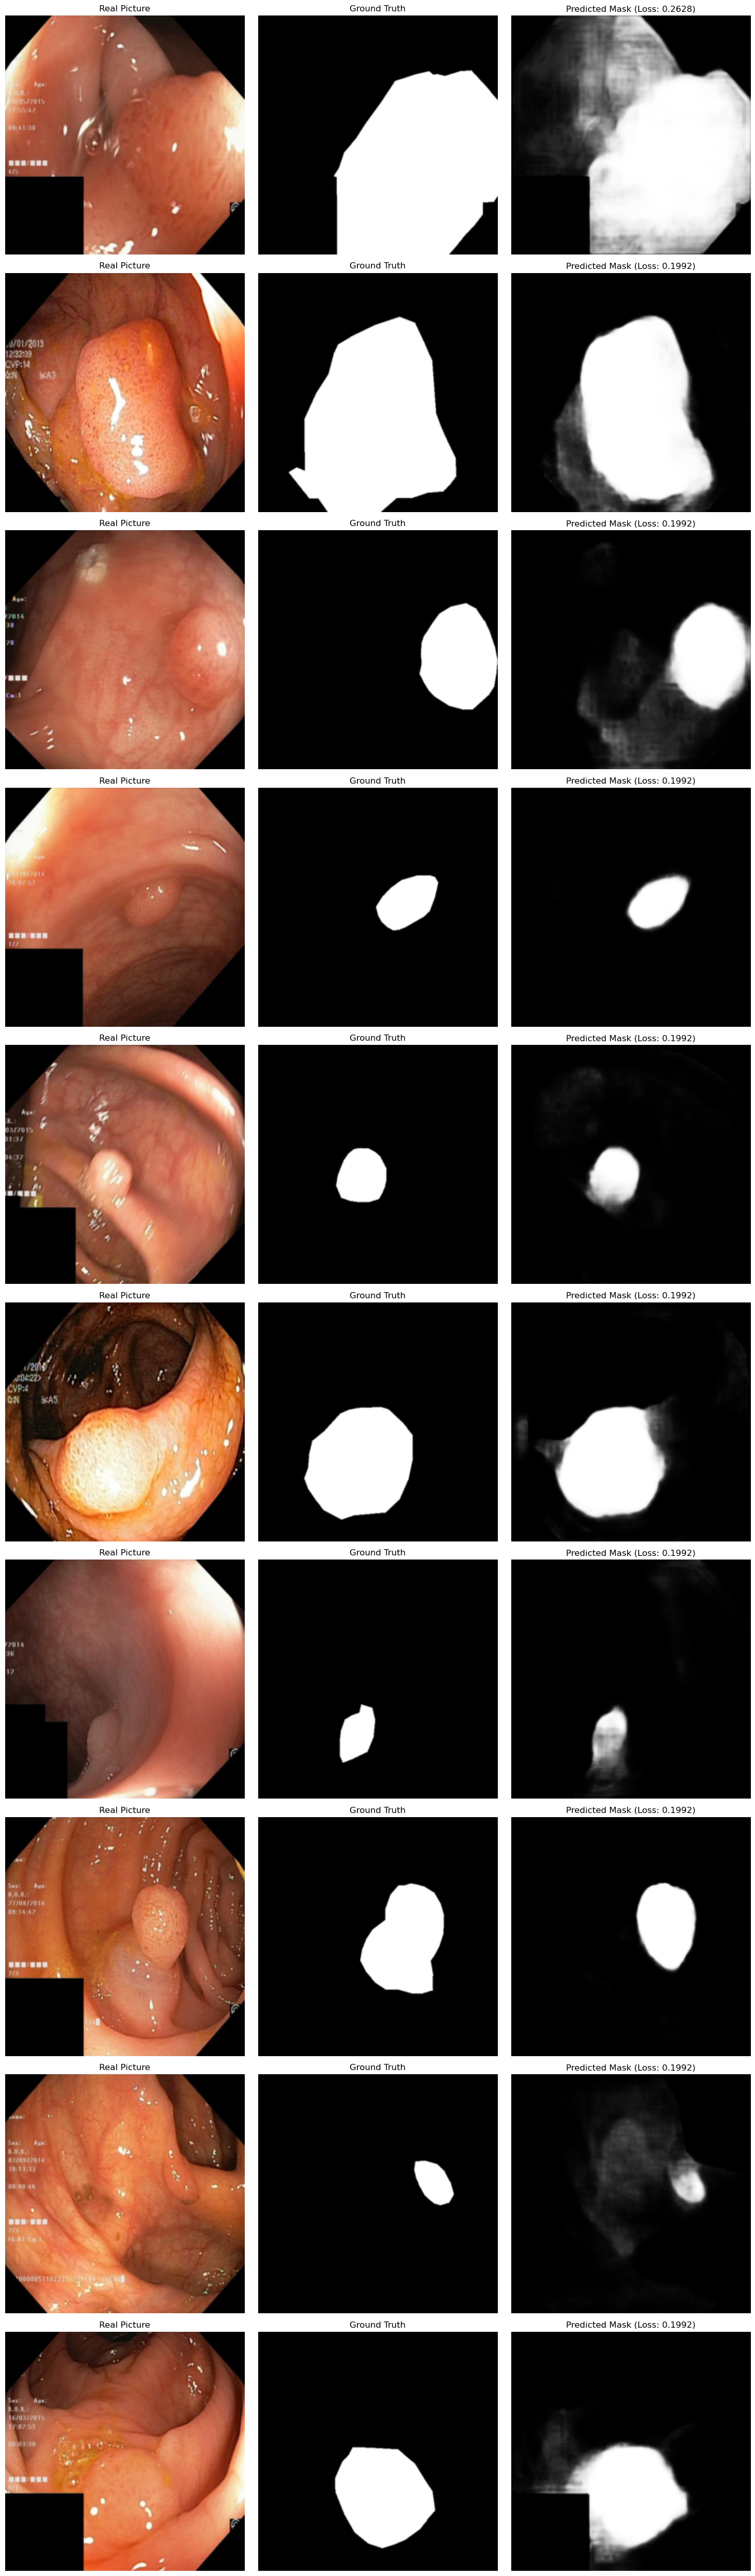

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def dice_coefficient(pred, target, smooth=1e-6):
    # Ensure the tensors have the same shape by squeezing the target
    if target.dim() == 4 and target.size(1) == 1:
        target = target.squeeze(1)
    
    # If the tensors have three dimensions (batch_size, H, W), unsqueeze the pred tensor
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
        target = target.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) + smooth)
    return dice.mean()

def iou(pred, target, smooth=1e-6):
    # Ensure the tensors have the same shape by squeezing the target
    if target.dim() == 4 and target.size(1) == 1:
        target = target.squeeze(1)
    
    # If the tensors have three dimensions (batch_size, H, W), unsqueeze the pred tensor
    if pred.dim() == 3:
        pred = pred.unsqueeze(1)
        target = target.unsqueeze(1)
    
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


def save_wrong_predictions(model, val_loader, num_images=10):
    model.eval()
    wrong_predictions = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.squeeze(1)  # Assuming outputs are [batch_size, 1, H, W]

            # Resizing masks if necessary
            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)

            # Calculate the dice coefficient and IoU for each prediction
            dice_scores = dice_coefficient(outputs, masks)
            ious = iou(outputs, masks)

            # Calculate the loss for each image
            losses = 1 - dice_coefficient(outputs, masks)

            # Iterate over the batch
            for i in range(images.size(0)):
                if len(wrong_predictions) < num_images:
                    wrong_predictions.append((images[i], masks[i], outputs[i], losses.item()))
                else:
                    # Keep the top num_images most incorrect predictions
                    max_loss = max(wrong_predictions, key=lambda x: x[3])
                    if losses.item() > max_loss[3]:
                        max_idx = wrong_predictions.index(max_loss)
                        wrong_predictions[max_idx] = (images[i], masks[i], outputs[i], losses.item())

    return wrong_predictions


# Function to plot the most incorrect predictions
def plot_wrong_predictions(wrong_predictions):
    fig, axes = plt.subplots(len(wrong_predictions), 3, figsize=(15, len(wrong_predictions) * 5))
    
    for i, (image, mask, pred, loss) in enumerate(wrong_predictions):
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy array and transpose
        mask = mask.cpu().numpy()
        pred = pred.cpu().numpy()

        # Original Image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Real Picture')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        # Predicted Mask
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title('Predicted Mask (Loss: {:.4f})'.format(loss))
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Get the most incorrect predictions
wrong_predictions = save_wrong_predictions(Attntion_WD_Aug_model, val_loader, num_images=10)

# Plot the most incorrect predictions
plot_wrong_predictions(wrong_predictions)
